In [1]:
import jax.numpy as jnp
from jax import lax
from jax import jit
from functools import partial
from jax.nn import softmax


def _normalize(u, axis=0, eps=1e-15):
    """Normalizes the values within the axis in a way that they sum up to 1.
    Args:
        u: Input array to normalize.
        axis: Axis over which to normalize.
        eps: Minimum value threshold for numerical stability.
    Returns:
        Tuple of the normalized values, and the normalizing denominator.
    """
    u = jnp.where(u == 0, 0, jnp.where(u < eps, eps, u))
    c = u.sum(axis=axis)
    c = jnp.where(c == 0, 1, c)
    return u / c, c


# Helper functions for the two key filtering steps
def _condition_on(probs, ll):
    """Condition on new emissions, given in the form of log likelihoods
    for each discrete state, while avoiding numerical underflow.
    Args:
        probs(k): prior for state k
        ll(k): log likelihood for state k
    Returns:
        probs(k): posterior for state k
    """
    ll_max = ll.max()
    new_probs = probs * jnp.exp(ll - ll_max)
    new_probs, norm = _normalize(new_probs)
    log_norm = jnp.log(norm) + ll_max
    return new_probs, log_norm


def _predict(probs, A):
    return A.T @ probs


@partial(jit)
def hmm_filter(
    initial_distribution,
    transition_matrix,
    log_likelihoods,
):
    r"""Forwards filtering
    Transition matrix may be either 2D (if transition probabilities are fixed) or 3D
    if the transition probabilities vary over time. Alternatively, the transition
    matrix may be specified via `transition_fn`, which takes in a time index $t$ and
    returns a transition matrix.
    Args:
        initial_distribution: $p(z_1 \mid u_1, \theta)$
        transition_matrix: $p(z_{t+1} \mid z_t, u_t, \theta)$
        log_likelihoods: $p(y_t \mid z_t, u_t, \theta)$ for $t=1,\ldots, T$.
    Returns:
        filtered posterior distribution
    """
    num_timesteps, num_states = log_likelihoods.shape

    def _step(carry, t):
        log_normalizer, predicted_probs = carry

        ll = log_likelihoods[t]

        filtered_probs, log_norm = _condition_on(predicted_probs, ll)
        log_normalizer += log_norm
        predicted_probs_next = _predict(filtered_probs, transition_matrix)

        return (log_normalizer, predicted_probs_next), (filtered_probs, predicted_probs)

    carry = (0.0, initial_distribution)
    (log_normalizer, _), (filtered_probs, predicted_probs) = lax.scan(
        _step, carry, jnp.arange(num_timesteps)
    )

    return log_normalizer, filtered_probs, predicted_probs


def centered_softmax_forward(y):
    """`softmax(x) = exp(x-c) / sum(exp(x-c))` where c is the last coordinate

    Example
    -------
    > y = np.log([2, 3, 4])
    > np.allclose(centered_softmax_forward(y), [0.2, 0.3, 0.4, 0.1])
    """
    if y.ndim == 1:
        y = jnp.append(y, 0)
    else:
        y = jnp.column_stack((y, jnp.zeros((y.shape[0],))))

    return softmax(y, axis=-1)


def centered_softmax_inverse(y):
    """`softmax(x) = exp(x-c) / sum(exp(x-c))` where c is the last coordinate

    Example
    -------
    > y = np.asarray([0.2, 0.3, 0.4, 0.1])
    > np.allclose(np.exp(centered_softmax_inverse(y)), np.asarray([2,3,4]))
    """
    return jnp.log(y[..., :-1]) - jnp.log(y[..., [-1]])


In [2]:
import jax
import numpy as np

from src.test_non_local_model import fit_regression
from tqdm.auto import tqdm


def create_initial_unconstrained_parameters(
    spikes,
    is_training,
    initial_conditions,
    discrete_state_transitions,
    design_matrix,
    estimate_initial_conditions=True,
    estimate_discrete_state_transitions=True,
    estimate_observation_coefficients=True,
):
    """Creates the initial parameters for the optimization

    Parameters
    ----------
    spikes : np.ndarray, shape (n_time, n_neurons)
    is_training : np.ndarray, shape (n_time,)
    n_observation_coefficients : int
    n_neurons : int
    n_states : int

    Returns
    -------
    x0 : np.ndarray, shape (n_parameters,)
    """
    unconstrained_parameters = []

    if estimate_observation_coefficients:
        # n_observation_coefficients, n_neurons = design_matrix.shape[1], spikes.shape[1]
        # observation_coefficients = np.ones((n_observation_coefficients, n_neurons))
        # observation_coefficients[0] = spikes[is_training].mean(axis=0)

        # unconstrained_parameters.append(
        #     np.log(
        #         observation_coefficients
        #     ).ravel()  # n_observation_coefficients * n_neurons
        # )
        
        observation_coefficients = np.stack(
                [
                    fit_regression(
                        design_matrix,
                        is_training.astype(float),
                        s,
                    )
                    for s in tqdm(spikes.T)
                ], axis=1
        )

        unconstrained_parameters.append(
            observation_coefficients.ravel()  # n_observation_coefficients * n_neurons
        )

    if estimate_initial_conditions:
        unconstrained_parameters.append(
            centered_softmax_inverse(initial_conditions)  # n_state_bins - 1
        )

    if estimate_discrete_state_transitions:
        unconstrained_parameters.append(
            centered_softmax_inverse(
                discrete_state_transitions
            ).ravel()  # n_states * (n_states - 1)
        )

    return np.concatenate(unconstrained_parameters)


def transform_parameters(
    unconstrained_parameters,
    n_observation_coefficients,
    n_neurons,
    n_states,
    n_state_bins,
):

    n_total_observation_coefficients = n_observation_coefficients * n_neurons
    observation_coefficients = unconstrained_parameters[
        :n_total_observation_coefficients
    ].reshape((n_observation_coefficients, n_neurons))

    unconstrained_initial_distribution = unconstrained_parameters[
        n_total_observation_coefficients : n_total_observation_coefficients
        + n_state_bins
        - 1
    ]

    unconstrained_discrete_state_transitions = unconstrained_parameters[
        n_total_observation_coefficients + n_state_bins - 1 :
    ].reshape((n_states, n_states - 1))

    initial_distribution = centered_softmax_forward(unconstrained_initial_distribution)
    discrete_state_transitions = centered_softmax_forward(
        unconstrained_discrete_state_transitions
    )

    return observation_coefficients, initial_distribution, discrete_state_transitions


def transform_initial_conditions(
    unconstrained_parameters,
):
    return centered_softmax_forward(unconstrained_parameters)


def transform_discrete_state_transitions(unconstrained_parameters, n_states):
    return centered_softmax_forward(
        unconstrained_parameters.reshape((n_states, n_states - 1))
    )


def transform_observation_coefficients(
    unconstrained_parameters, n_observation_coefficients, n_neurons
):
    return unconstrained_parameters.reshape((n_observation_coefficients, n_neurons))


@jax.jit
def neglogp(
    unconstrained_parameters,
    spikes,
    zero_rates,
    design_matrix,
    predict_matrix,
    continuous_state_transitions,
    state_ind,
    eps=1e-15,
):

    n_states = 3
    n_time, n_neurons = spikes.shape
    n_state_bins = len(state_ind)
    n_observation_coefficients = design_matrix.shape[1]

    (
        observation_coefficients,
        initial_distribution,
        discrete_state_transitions,
    ) = transform_parameters(
        unconstrained_parameters,
        n_observation_coefficients,
        n_neurons,
        n_states,
        n_state_bins,
    )

    local_rates = jnp.exp(
        design_matrix @ observation_coefficients
    )  # shape (n_time, n_neurons)
    local_rates = jnp.clip(local_rates, a_min=eps, a_max=None)

    observation_log_likelihood = jnp.zeros((n_time, n_state_bins))

    # Local state
    observation_log_likelihood = observation_log_likelihood.at[:, 0].set(
        jnp.sum(jax.scipy.stats.poisson.logpmf(spikes, local_rates), axis=-1)
    )

    # No-spike state
    observation_log_likelihood = observation_log_likelihood.at[:, 1].set(
        jnp.sum(jax.scipy.stats.poisson.logpmf(spikes, zero_rates), axis=-1)
    )

    # Non-local state
    non_local_rates = jnp.exp(predict_matrix @ observation_coefficients)
    non_local_rates = jnp.clip(non_local_rates, a_min=eps, a_max=None)
    for is_spike, rate in zip(spikes.T, non_local_rates.T):
        observation_log_likelihood = observation_log_likelihood.at[:, 2:].add(
            jax.scipy.stats.poisson.logpmf(is_spike[:, jnp.newaxis], rate[jnp.newaxis])
        )

    discrete_state_transitions_per_bin = discrete_state_transitions[
        jnp.ix_(state_ind, state_ind)
    ]

    transition_matrix = (
        discrete_state_transitions_per_bin * continuous_state_transitions
    )

    marginal_log_likelihood, _, _ = hmm_filter(
        initial_distribution, transition_matrix, observation_log_likelihood
    )

    return -1.0 * marginal_log_likelihood


dlike = jax.grad(neglogp)


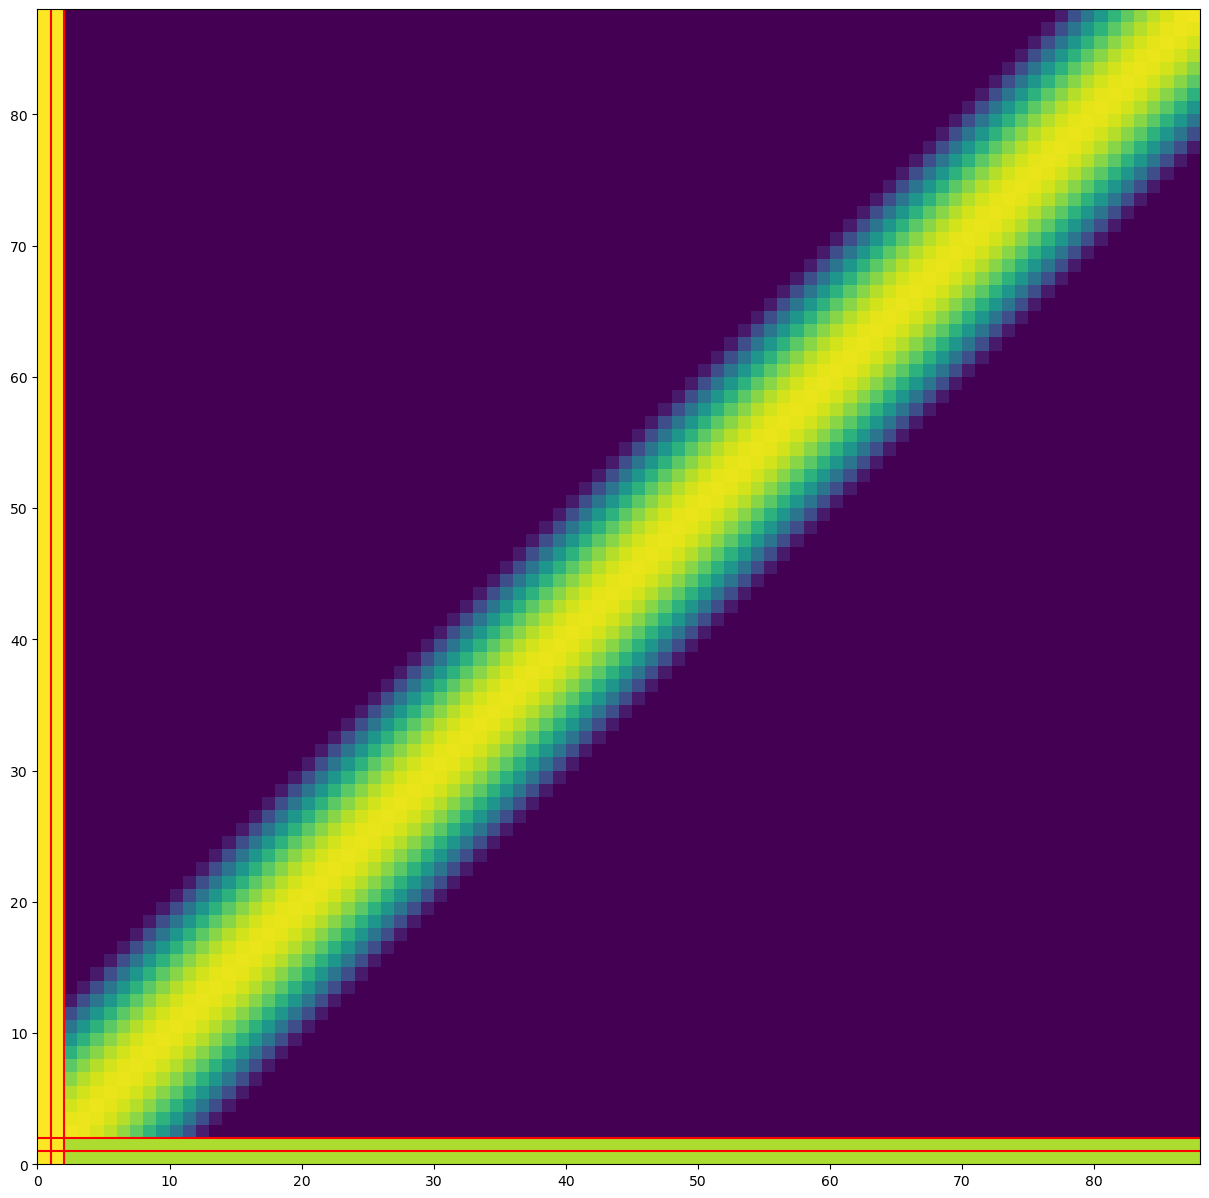

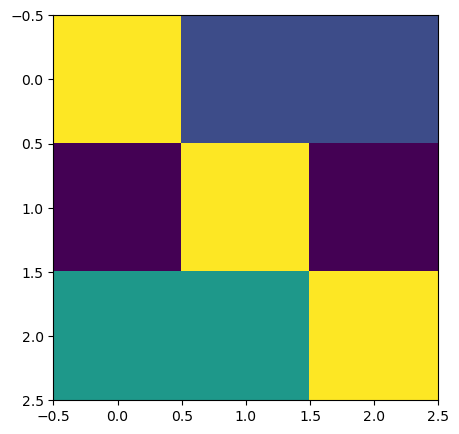

In [3]:
from src.simulate import make_simulated_data
import matplotlib.pyplot as plt
from replay_trajectory_classification import Environment
from src.test_non_local_model import setup_nonlocal_switching_model

speed, position, spikes, time, ripple_times, sampling_frequency = make_simulated_data()

spikes[slice(80_000, 89_000), :] = 0.0

is_ripple = speed < 0.0

env = Environment().fit_place_grid(position[:, np.newaxis])

(
    design_matrix,
    predict_matrix,
    initial_conditions,
    discrete_state_transitions,
    continuous_state_transitions,
    state_ind,
    zero_rates,
    is_training,
    state_names,
) = setup_nonlocal_switching_model(
    is_ripple,
    spikes,
    position,
    env,
)

initial_conditions[0] = 1 - 1e-15
initial_conditions[1:] = 1e-15 / len(initial_conditions[1:])

In [4]:
from scipy.optimize import minimize


x0 = create_initial_unconstrained_parameters(
    spikes,
    is_training,
    initial_conditions,
    discrete_state_transitions,
    design_matrix,
)


res = minimize(
    neglogp,
    x0=x0,
    method="BFGS",
    jac=dlike,
    args=(
        spikes,
        zero_rates,
        design_matrix,
        predict_matrix,
        continuous_state_transitions,
        state_ind,
    ),
    options={'gtol': 1e-15, 'disp': True}
)

res.x

  0%|          | 0/8 [00:00<?, ?it/s]

         Current function value: 8221.697266
         Iterations: 32
         Function evaluations: 180
         Gradient evaluations: 168


array([-4.14702492e+00, -5.95403947e+00, -4.91934333e+03, -8.33665568e+01,
       -3.66737648e+01, -4.81672717e+02, -1.33232102e+01, -5.44487672e+01,
       -3.74398109e-01, -6.78003465e-01,  4.91177336e+03, -2.88511475e+01,
       -1.00774364e+01, -2.18999332e+02, -6.36772887e+00, -1.91597529e+01,
        1.11915675e-01,  1.29162315e+00,  4.91137506e+03, -4.49333648e+00,
       -5.03605696e+00, -1.11372116e+02, -1.76201113e+00, -1.74687342e+01,
       -1.25067202e+00,  8.45656516e-01,  4.91022156e+03, -2.18917546e+02,
       -4.29212405e+00, -2.23466611e+02, -2.37782276e+00, -1.88967524e+01,
       -4.98480225e+00,  1.99693382e+00,  4.91561762e+03,  8.02324080e+01,
        8.14523882e-02, -1.80565129e+02, -1.52258800e+00, -8.96803366e+00,
        4.82675447e+00, -1.38475242e+00,  4.91485035e+03,  7.74393317e+01,
        2.66427030e+01,  4.50624973e+02, -2.61396773e+00, -5.78464249e+00,
       -3.29128024e+06, -1.11591951e+01,  4.91057892e+03,  8.08699830e+01,
        3.30901953e+01,  

In [5]:
n_states = 3
n_time, n_neurons = spikes.shape
n_state_bins = len(state_ind)
n_observation_coefficients = design_matrix.shape[1]

(
    estimated_observation_coefficients,
    estimated_initial_distribution,
    estimated_discrete_state_transitions,
) = transform_parameters(
    res.x,
    n_observation_coefficients,
    n_neurons,
    n_states,
    n_state_bins,
)

In [6]:
estimated_discrete_state_transitions[np.arange(3), np.arange(3)]

Array([0.99993885, 0.9998789 , 0.9877186 ], dtype=float32)

In [7]:
@jax.jit
def get_acausal(
    unconstrained_parameters,
    spikes,
    zero_rates,
    design_matrix,
    predict_matrix,
    continuous_state_transitions,
    state_ind,
    eps=1e-15,
):

    n_states = 3
    n_time, n_neurons = spikes.shape
    n_state_bins = len(state_ind)
    n_observation_coefficients = design_matrix.shape[1]

    (
        observation_coefficients,
        initial_distribution,
        discrete_state_transitions,
    ) = transform_parameters(
        unconstrained_parameters,
        n_observation_coefficients,
        n_neurons,
        n_states,
        n_state_bins,
    )

    local_rates = jnp.exp(
        design_matrix @ observation_coefficients
    )  # shape (n_time, n_neurons)
    local_rates = jnp.clip(local_rates, a_min=eps, a_max=None)

    observation_log_likelihood = jnp.zeros((n_time, n_state_bins))

    # Local state
    observation_log_likelihood = observation_log_likelihood.at[:, 0].set(
        jnp.sum(jax.scipy.stats.poisson.logpmf(spikes, local_rates), axis=-1)
    )

    # No-spike state
    observation_log_likelihood = observation_log_likelihood.at[:, 1].set(
        jnp.sum(jax.scipy.stats.poisson.logpmf(spikes, zero_rates), axis=-1)
    )

    # Non-local state
    non_local_rates = jnp.exp(predict_matrix @ observation_coefficients)
    non_local_rates = jnp.clip(non_local_rates, a_min=eps, a_max=None)
    for is_spike, rate in zip(spikes.T, non_local_rates.T):
        observation_log_likelihood = observation_log_likelihood.at[:, 2:].add(
            jax.scipy.stats.poisson.logpmf(is_spike[:, jnp.newaxis], rate[jnp.newaxis])
        )

    discrete_state_transitions_per_bin = discrete_state_transitions[
        jnp.ix_(state_ind, state_ind)
    ]

    transition_matrix = (
        discrete_state_transitions_per_bin * continuous_state_transitions
    )

    marginal_log_likelihood, filtered_probs, predicted_probs = hmm_filter(
        initial_distribution, transition_matrix, observation_log_likelihood
    )
    
    # Run the smoother backward in time
    def _step(carry, args):
        # Unpack the inputs
        smoothed_probs_next = carry
        t, filtered_probs, predicted_probs_next = args

        # Fold in the next state (Eq. 8.2 of Saarka, 2013)
        # If hard 0. in predicted_probs_next, set relative_probs_next as 0. to avoid NaN values
        relative_probs_next = jnp.where(jnp.isclose(predicted_probs_next, 0.0), 0.0,
                                        smoothed_probs_next / predicted_probs_next)
        smoothed_probs = filtered_probs * (transition_matrix @ relative_probs_next)
        smoothed_probs /= smoothed_probs.sum()

        return smoothed_probs, smoothed_probs

    # Run the HMM smoother
    carry = filtered_probs[-1]
    args = (jnp.arange(n_time - 2, -1, -1), filtered_probs[:-1][::-1], predicted_probs[1:][::-1])
    _, rev_smoothed_probs = lax.scan(_step, carry, args)

    # Reverse the arrays and return
    smoothed_probs = jnp.row_stack([rev_smoothed_probs[::-1], filtered_probs[-1]])

    return smoothed_probs

In [8]:
acausal_posterior = get_acausal(
    res.x,
    spikes,
    zero_rates,
    design_matrix,
    predict_matrix,
    continuous_state_transitions,
    state_ind,
    eps=1e-15,
)

In [9]:
acausal_state_probabilities = np.concatenate((acausal_posterior[:, :2], acausal_posterior[:, 2:].sum(axis=1, keepdims=True)), axis=1)

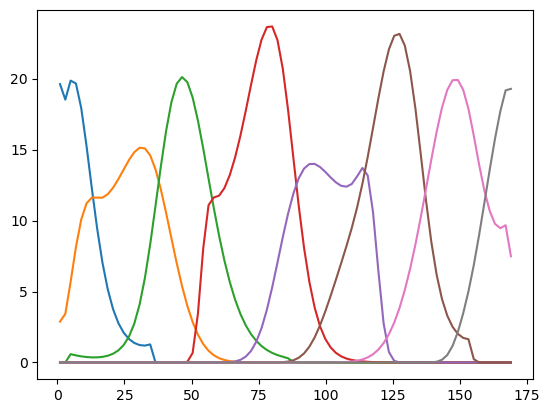

In [10]:
non_local_rates = np.exp(predict_matrix @ estimated_observation_coefficients)

plt.plot(env.place_bin_centers_, non_local_rates * sampling_frequency)

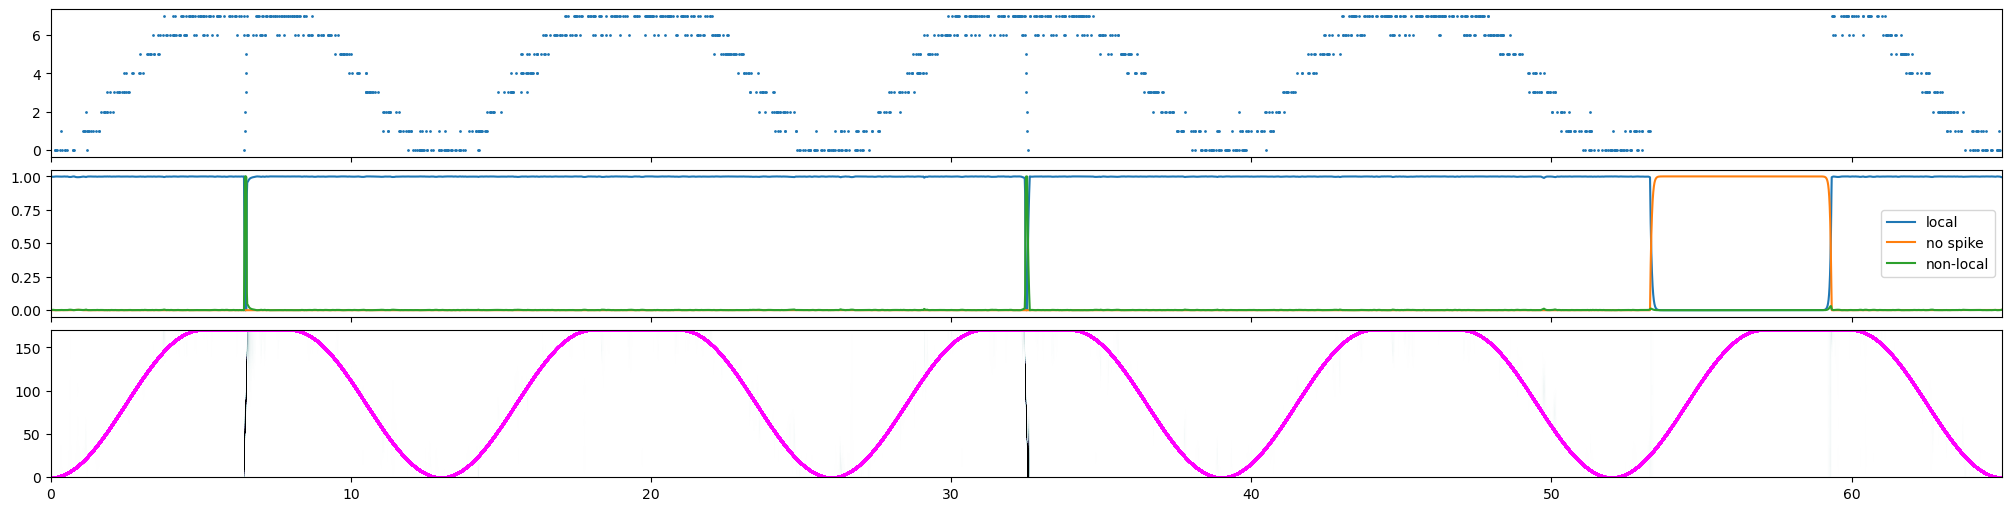

In [11]:
from src.test_non_local_model import plot_switching_model

plot_switching_model(
    time,
    position,
    spikes,
    non_local_rates,
    env,
    state_ind,
    acausal_state_probabilities,
    acausal_posterior,
    state_names,
    time_slice=slice(0, n_time),
)

In [12]:
estimated_discrete_state_transitions[np.arange(3), np.arange(3)]

Array([0.99993885, 0.9998789 , 0.9877186 ], dtype=float32)